<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/exp8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText xfeat category_encoders texthero  umap transformers MulticoreTSNE
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 29.35 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [3]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from fasttext import load_model
from tqdm import tqdm
tqdm.pandas()

sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPUT_PATH = "/content/drive/MyDrive/atmacup10/data/submission/"

from typing import Tuple
from pprint import pprint
from PIL import ImageColor
import colorsys

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [4]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

@cachable
def read_csv(name):

    if '.csv' not in name:
        name = name + '.csv'

    return pd.read_csv(os.path.join(INPUT_PATH, name))

def whole_df():
  return pd.concat([read_csv("train"), read_csv("test")], ignore_index=True).reset_index

train_df = read_csv("train")
test_df = read_csv("test")
maker = read_csv("maker")
color_df = read_csv("color")

run
run
run
run


In [5]:
color_object_id = pd.DataFrame(
    color_df["object_id"]
)
rgb_df = pd.DataFrame(color_df["hex"].str.strip().map(ImageColor.getrgb).values.tolist(), columns=["R", "G", "B"])

In [6]:
new_color_df = pd.concat([color_object_id, rgb_df], axis=1)
new_color_df["rgb_mean"] = (new_color_df["R"] + new_color_df["G"] + new_color_df["B"]) / 3

In [7]:
std_color_df = new_color_df.groupby("object_id")[["R", "G", "B", "rgb_mean"]].std().add_prefix("std_")
train_df = pd.merge(train_df, std_color_df, on="object_id", how="left")
test_df = pd.merge(test_df, std_color_df, on="object_id", how="left")

In [8]:
min_color_df = new_color_df.groupby("object_id")[["R", "G", "B", "rgb_mean"]].min()
max_color_df = new_color_df.groupby("object_id")[["R", "G", "B", "rgb_mean"]].max()
max_min_color_df = max_color_df[["R", "G", "B", "rgb_mean"]] - min_color_df[["R", "G", "B", "rgb_mean"]]
max_min_color_df = max_min_color_df.add_prefix("max_min_")

In [9]:
train_df = pd.merge(train_df, max_min_color_df, on="object_id", how="left")
test_df = pd.merge(test_df, max_min_color_df, on="object_id", how="left")

In [10]:
train_df = pd.merge(train_df, maker, left_on="principal_maker", right_on="name", how="left")
test_df = pd.merge(test_df, maker, left_on="principal_maker", right_on="name", how="left")


train_df["acquisition_date"] = pd.to_datetime(train_df["acquisition_date"])
train_df["acquisition_date"] = train_df['acquisition_date'].dt.strftime("%Y")

test_df["acquisition_date"] = pd.to_datetime(test_df["acquisition_date"])
test_df["acquisition_date"] = test_df['acquisition_date'].dt.strftime("%Y")

train_df["date_of_birth"] = train_df["date_of_birth"].str[:4]
train_df["date_of_death"] = train_df["date_of_death"].str[:4]
train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)


test_df["date_of_birth"] = test_df["date_of_birth"].str[:4]
test_df["date_of_death"] = test_df["date_of_death"].str[:4]
test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)


train_df["age"] = train_df["date_of_death"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["age"] = train_df["age"].fillna("NaN")
train_df["age"] = train_df["age"].astype(float)

test_df["age"] = test_df["date_of_death"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["age"] = test_df["age"].fillna("NaN")
test_df["age"] = test_df["age"].astype(float)


train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_birth"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_death"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "age"] = "NaN"

test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_birth"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_death"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "age"] = "NaN"

train_df["age"] = train_df["age"].astype(float)
test_df["age"] = test_df["age"].astype(float)

train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)

test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)


#制作期間が長いほど名作なのでは
train_df["period_of_production"] = train_df["dating_year_late"].astype(float) - train_df["dating_year_early"].astype(float)
train_df["period_of_production"] = train_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
train_df["period_between_death_year_and_late_year"] = train_df["date_of_death"].astype(float) - train_df["dating_year_late"].astype(float)
train_df["period_between_death_year_and_late_year"] = train_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
train_df["period_between_acquistion_date_and_date_death"] = train_df["acquisition_date"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_acquistion_date_and_date_death"] = train_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["dating_year_late"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

#制作期間が長いほど名作なのでは
test_df["period_of_production"] = test_df["dating_year_late"].astype(float) - test_df["dating_year_early"].astype(float)
test_df["period_of_production"] = test_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
test_df["period_between_death_year_and_late_year"] = test_df["date_of_death"].astype(float) - test_df["dating_year_late"].astype(float)
test_df["period_between_death_year_and_late_year"] = test_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
test_df["period_between_acquistion_date_and_date_death"] = test_df["acquisition_date"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_acquistion_date_and_date_death"] = test_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["dating_year_late"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

train_df["last_work_vs_first_work"] = train_df["period_between_death_year_and_late_year"] - train_df["period_between_date_of_birth_and_dating_year_late"]
test_df["last_work_vs_first_work"] = test_df["period_between_death_year_and_late_year"] - test_df["period_between_date_of_birth_and_dating_year_late"]


train_df["is_coworking"] = train_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)
test_df["is_coworking"] = test_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)

In [12]:
tmp_1 = pd.read_pickle(OUTPUT_PATH + "train_image_feature.pkl")
tmp_2 = pd.read_pickle(OUTPUT_PATH + "test_image_feature.pkl")

train_object_id = pd.DataFrame(
    tmp_1["object_id"]
)
test_object_id = pd.DataFrame(
    tmp_2["object_id"]
)

train_object_id = train_object_id.reset_index()
test_object_id = test_object_id.reset_index()

train_object_id = train_object_id.drop(columns=["index"])
test_object_id = test_object_id.drop(columns=["index"])

def create_for_reduction(input_df):
  out_df = pd.DataFrame(
      np.stack(input_df["feature"])
  )

  return out_df

from sklearn.decomposition import PCA, TruncatedSVD

def result_color_pca(N, input_df):
  pca = PCA(n_components=N).fit(create_for_reduction(input_df))
  transformed = pca.transform(create_for_reduction(input_df))
  for n in range(N):
    print(f"第{n+1} 主成分:{pca.explained_variance_ratio_[n]}")
    out_df = pd.DataFrame(
        transformed,
        columns=[f"pca_{n+1}_color_feature" for n in range(N)]
    )

  return out_df



train_result_pca = result_color_pca(N=6, input_df=tmp_1)
test_result_pca = result_color_pca(N=6, input_df=tmp_2)

train_reduction_df = pd.concat([train_object_id, train_result_pca], axis=1)
test_reduction_df = pd.concat([test_object_id, test_result_pca], axis=1)

train_df = pd.merge(train_df, train_reduction_df, on="object_id", how="left")
test_df = pd.merge(test_df, test_reduction_df, on="object_id", how="left")

第1 主成分:0.2644466757774353
第2 主成分:0.1743268519639969
第3 主成分:0.12500233948230743
第4 主成分:0.10745316743850708
第5 主成分:0.059304460883140564
第6 主成分:0.058309707790613174
第1 主成分:0.26810184121131897
第2 主成分:0.17373128235340118
第3 主成分:0.12196862697601318
第4 主成分:0.10885245352983475
第5 主成分:0.058579083532094955
第6 主成分:0.056378260254859924


In [13]:

OBJECT_ID = "object_id"
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

os.chdir(CODE_PATH)
from util import AbstractBaseBlock
from feature_engine import *
class MaterialBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      material_df = read_csv('material')
      vc = material_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = material_df['name'].isin(use_names)
      _use_df = material_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'MaterialBlock_name=')


class TechiqueBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      techique_df = read_csv('technique')
      vc = technique_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = technique_df['name'].isin(use_names)
      _use_df = technique_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'TechniqueBlock_name=')

class CollectionBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      collection_df = read_csv('object_collection')
      vc = collection_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = collection_df['name'].isin(use_names)
      _use_df = collection_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'CollectionBlock_name=')


class GetLanguageLabel(AbstractBaseBlock):
  """
  言語判定するブロック
  """
  def __init__(self, cols):
    self.cols = cols

  def fit(self, input_df):
    return self.transform(input_df)

  def transform(self, input_df):
    out_df = pd.DataFrame()
    self.model = load_model("/content/drive/MyDrive/atmacup10/data/img/lid.176.bin")
    out_df[self.cols] = input_df[self.cols].fillna("").map(lambda x: self.model.predict(x.replace("\n", ""))[0][0])
    return out_df.add_prefix("lang_label_")

class GetCountString(AbstractBaseBlock):  
  """
  文字数を取得するブロック
  """
  def __init__(self, cols):
    self.cols = cols

  def transform(self, input_df):
    _input_df = input_df[self.cols].fillna("NaN")
    out_df = pd.DataFrame()
    out_df[self.cols] = input_df[self.cols].fillna("NaN").str.len()
    return out_df.add_prefix("count_string_")

from gensim.models import word2vec

model_size = {
    "material": 20,
    "technique": 8,
    "collection": 3,
    "material_collection": 20,
    "material_technique": 20,
    "collection_technique": 10,
    "material_collection_technique": 25
}


class Word2VecBlock(AbstractBaseBlock):
  def __init__(self, model_size:tuple):
    self.model_size = model_size

  def fit(self, input_df, y=None):
    material_df = read_csv("material")
    technique_df = read_csv("technique")
    collection = read_csv("object_collection")

    mat_col = pd.concat([material_df, collection], axis=0).reset_index(drop=True)
    mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
    col_tec = pd.concat([collection, technique_df], axis=0).reset_index(drop=True)
    mat_col_tec = pd.concat([material_df, collection, technique_df], axis=0).reset_index(drop=True)

    w2v_dfs = []
    for df, df_name in zip(
            [
                material_df, collection, technique_df,
                mat_col, mat_tec, col_tec, mat_col_tec
            ], [
                "material", "collection", "technique",
                "material_collection",
                "material_technique",
                "collection_technique",
                "material_collection_technique"
            ]):
        df_group = df.groupby("object_id")["name"].apply(list).reset_index()
        # Word2Vecの学習
        w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                      size=model_size[df_name],
                                      min_count=1,
                                      window=1,
                                      iter=100)

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = df_group["name"].progress_apply(
            lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{df_name}_w2v_{i}"
                                                  for i in range(model_size[df_name])])
        sentence_vector_df.index = df_group["object_id"]
        w2v_dfs.append(sentence_vector_df)

    tmp_2 = pd.merge(w2v_dfs[0], w2v_dfs[1], on='object_id', how="left")
    tmp_3 = pd.merge(w2v_dfs[2], w2v_dfs[3], on='object_id', how="left")
    tmp_4 = pd.merge(w2v_dfs[4], w2v_dfs[5], on='object_id', how="left")
    tmp_5 = pd.merge(tmp_2, w2v_dfs[6], on="object_id", how="left")
    tmp_2 = pd.merge(tmp_3, tmp_4, on="object_id", how="left")
    self._df = pd.merge(tmp_5, tmp_2, on="object_id", how="left")

    return self.transform(input_df)
      
  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df = left_join(input_df, self._df)
    return out_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [14]:
from time import time
from tqdm import tqdm
from contextlib import contextmanager

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        print(len(_df), len(input_df))
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [32]:
add_feature_block = [
                     GetLanguageLabel("title"),
                     GetLanguageLabel("description"),
                     GetLanguageLabel("long_title"),
                     GetCountString("title"),
                     GetCountString("description"),
                     GetCountString("acquisition_credit_line"),
                     GetCountString("long_title"),
                     GetCountString("more_title"),
                     GetCountString("sub_title"),

]

train_feat_df = to_feature(train_df, train_df, add_feature_block, is_train=True)
test_feat_df = to_feature(test_df, test_df, add_feature_block, is_train=False)
print(train_df.shape, test_df.shape)

 11%|█         | 1/9 [00:00<00:04,  1.97it/s]

create<__main__.GetLanguageLabel object at 0x7f4b54571cd0> 0.499[s]
12026 12026


 22%|██▏       | 2/9 [00:01<00:04,  1.72it/s]

create<__main__.GetLanguageLabel object at 0x7f4b54571610> 0.728[s]
12026 12026


 78%|███████▊  | 7/9 [00:02<00:00,  2.35it/s]

create<__main__.GetLanguageLabel object at 0x7f4b545715d0> 0.602[s]
12026 12026
create<__main__.GetCountString object at 0x7f4b54571d10> 0.011[s]
12026 12026
create<__main__.GetCountString object at 0x7f4b54571c90> 0.011[s]
12026 12026
create<__main__.GetCountString object at 0x7f4b54571190> 0.009[s]
12026 12026
create<__main__.GetCountString object at 0x7f4b54571b10> 0.010[s]
12026 12026
create<__main__.GetCountString object at 0x7f4b54571390> 0.014[s]
12026 12026
create<__main__.GetCountString object at 0x7f4b545716d0> 0.009[s]
12026 12026


 11%|█         | 1/9 [00:00<00:03,  2.04it/s]

create<__main__.GetLanguageLabel object at 0x7f4b54571cd0> 0.483[s]
12008 12008


 22%|██▏       | 2/9 [00:01<00:03,  1.78it/s]

create<__main__.GetLanguageLabel object at 0x7f4b54571610> 0.708[s]
12008 12008


 78%|███████▊  | 7/9 [00:01<00:00,  2.42it/s]

create<__main__.GetLanguageLabel object at 0x7f4b545715d0> 0.588[s]
12008 12008
create<__main__.GetCountString object at 0x7f4b54571d10> 0.012[s]
12008 12008
create<__main__.GetCountString object at 0x7f4b54571c90> 0.012[s]
12008 12008
create<__main__.GetCountString object at 0x7f4b54571190> 0.010[s]
12008 12008
create<__main__.GetCountString object at 0x7f4b54571b10> 0.010[s]
12008 12008
create<__main__.GetCountString object at 0x7f4b54571390> 0.011[s]
12008 12008
create<__main__.GetCountString object at 0x7f4b545716d0> 0.009[s]
12008 12008


100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

(12026, 47) (12008, 46)


In [33]:

process_blocks = [
                 LabelEncodingBlock("acquisition_method"),
                 LabelEncodingBlock("principal_maker"),
                 LabelEncodingBlock("lang_label_title"),
                 LabelEncodingBlock("lang_label_description"),
                 LabelEncodingBlock("lang_label_long_title"),
                 LabelEncodingBlock("title"),
                 LabelEncodingBlock("description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 CountEncodingBlock("lang_label_title"),
                 CountEncodingBlock("lang_label_description"),
                 CountEncodingBlock("title"),
                 CountEncodingBlock("description"),
                 MaterialBlock(min_count=19),
                 CollectionBlock(min_count=3),
                 Word2VecBlock(model_size), 
                 AggregationBlock(group_key="principal_maker", 
                                   group_values=["count_string_description", 
                                                  "period_of_production", "period_between_acquistion_date_and_date_death",
                                                  "period_between_death_year_and_late_year", "last_work_vs_first_work"],
                                   agg_methods=["max", "min", "std", "median"]),
                 AggregationBlock(group_key="bins_age",
                                   group_values=["count_string_description", "period_of_production", "period_between_acquistion_date_and_date_death",
                                                  "period_between_death_year_and_late_year", "last_work_vs_first_work"],
                                   agg_methods=["max", "min", "std", "mean"])

                 ]
drop_columns = ["description", "title", "principal_maker", "principal_or_first_maker", "long_title", "art_series_id", "object_id", 
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "lang_label_title", "lang_label_description", "lang_label_long_title",
                  "dating_year_late", "dating_year_early", "nationality", "place_of_death", "place_of_birth", "name", "date_of_birth", "date_of_death"]

train_feat_df = to_feature(train_feat_df,train_feat_df.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test_feat_df,test_feat_df.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)

 33%|███▎      | 6/18 [00:00<00:00, 55.67it/s]

create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7f10> 0.011[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7dd0> 0.011[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7fd0> 0.011[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c73d0> 0.011[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7350> 0.010[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7ad0> 0.020[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7550> 0.021[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f4b545c7750> 0.010[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f4b54452cd0> 0.009[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f4b545c75d0> 0.010[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f4b545c7650> 0.009[s]
12026 12026


 67%|██████▋   | 12/18 [00:00<00:00, 53.77it/s]

create<feature_engine.CountEncodingBlock object at 0x7f4b545c77d0> 0.020[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f4b545c7690> 0.018[s]
12026 12026


 83%|████████▎ | 15/18 [00:00<00:00, 17.29it/s]

create<__main__.MaterialBlock object at 0x7f4b545c7450> 0.283[s]
12026 12026
create<__main__.CollectionBlock object at 0x7f4b545c7610> 0.123[s]
12026 12026



100%|██████████| 23586/23586 [00:00<00:00, 49089.12it/s]

100%|██████████| 14160/14160 [00:00<00:00, 51790.92it/s]

100%|██████████| 17329/17329 [00:00<00:00, 53210.97it/s]

100%|██████████| 23597/23597 [00:00<00:00, 47126.18it/s]

100%|██████████| 23950/23950 [00:00<00:00, 32175.01it/s]

100%|██████████| 21646/21646 [00:00<00:00, 50258.24it/s]

 89%|████████▉ | 16/18 [00:30<00:17,  8.99s/it]

create<__main__.Word2VecBlock object at 0x7f4b545c7410> 29.833[s]
12026 12026


 94%|█████████▍| 17/18 [00:30<00:06,  6.40s/it]

create<feature_engine.AggregationBlock object at 0x7f4b4edddb50> 0.343[s]
12026 12026


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

 33%|███▎      | 6/18 [00:00<00:00, 58.87it/s]

create<feature_engine.AggregationBlock object at 0x7f4b5457e9d0> 0.442[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7f10> 0.013[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7dd0> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7fd0> 0.011[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c73d0> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7350> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7ad0> 0.014[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f4b545c7550> 0.019[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f4b545c7750> 0.008[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f4b54452cd0> 0.009[s]
12008 12008


 89%|████████▉ | 16/18 [00:00<00:00, 47.99it/s]

create<feature_engine.CountEncodingBlock object at 0x7f4b545c75d0> 0.010[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f4b545c7650> 0.010[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f4b545c77d0> 0.014[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f4b545c7690> 0.021[s]
12008 12008
create<__main__.MaterialBlock object at 0x7f4b545c7450> 0.016[s]
12008 12008
create<__main__.CollectionBlock object at 0x7f4b545c7610> 0.012[s]
12008 12008
create<__main__.Word2VecBlock object at 0x7f4b545c7410> 0.028[s]
12008 12008
create<feature_engine.AggregationBlock object at 0x7f4b4edddb50> 0.359[s]
12008 12008


100%|██████████| 18/18 [00:01<00:00, 17.86it/s]

create<feature_engine.AggregationBlock object at 0x7f4b5457e9d0> 0.281[s]
12008 12008


In [34]:
y = np.log1p(train_df["likes"])
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [35]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [36]:
params = {
    "objective": "rmse",
    "max_depth": 5,
    "n_estimators": 100000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.09729
[1000]	valid_0's rmse: 1.0792
[1500]	valid_0's rmse: 1.07164
[2000]	valid_0's rmse: 1.0675
[2500]	valid_0's rmse: 1.06347
[3000]	valid_0's rmse: 1.06131
[3500]	valid_0's rmse: 1.0601
[4000]	valid_0's rmse: 1.06014
Early stopping, best iteration is:
[3771]	valid_0's rmse: 1.05976
fit fold=135.423[s]
K Fold 0 RMSLE: 1.0598
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.09229
[1000]	valid_0's rmse: 1.07609
[1500]	valid_0's rmse: 1.06893
[2000]	valid_0's rmse: 1.06447
[2500]	valid_0's rmse: 1.06274
[3000]	valid_0's rmse: 1.06184
[3500]	valid_0's rmse: 1.06133
[4000]	valid_0's rmse: 1.06128
Early stopping, best iteration is:
[3539]	valid_0's rmse: 1.06108
fit fold=233.022[s]
K Fold 1 RMSLE: 1.0611
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.0756
[1000]	valid_0's rmse: 1.05802
[1500]	valid_0's rmse: 1.05035
[2000]	vali

In [37]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[3:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

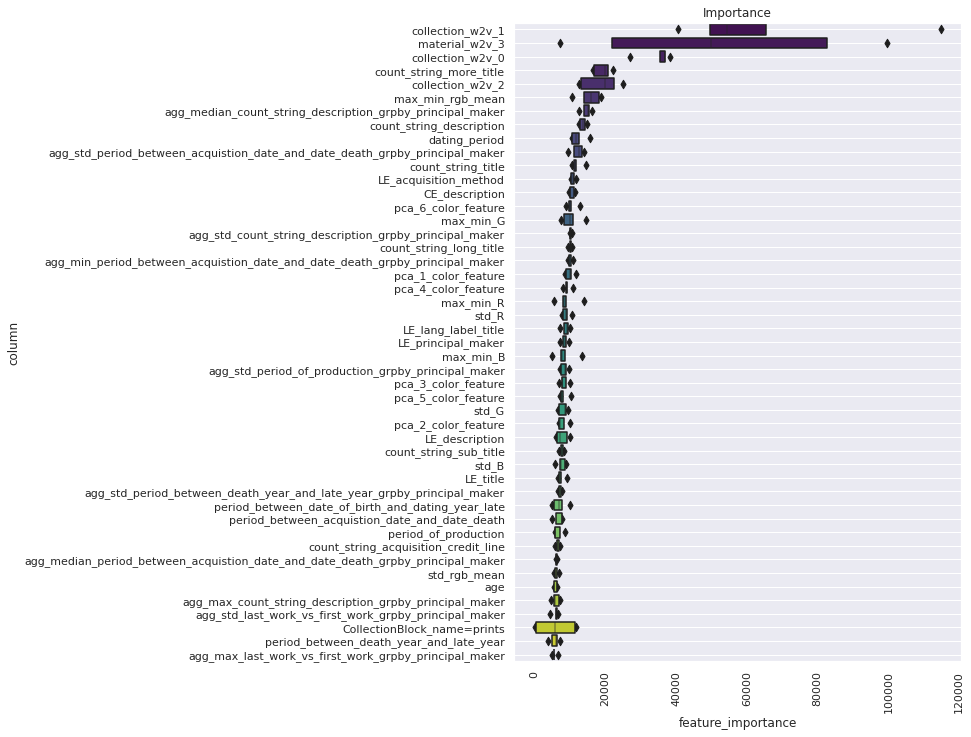

In [38]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

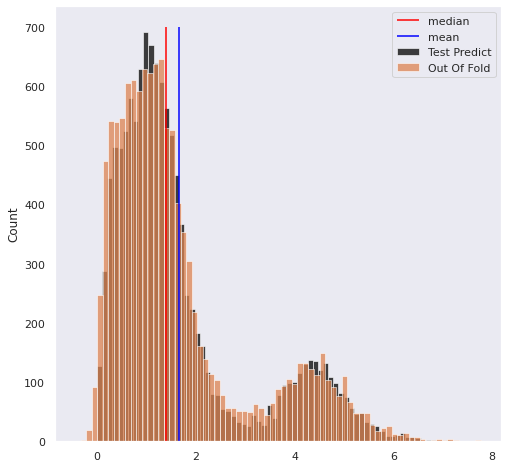

In [39]:

def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred


pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })

fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
plt.vlines(np.median(np.log1p(train_df["likes"])), ymin=0, ymax=700, color="red", label="median")
plt.vlines(np.mean(np.log1p(train_df["likes"])), ymin=0, ymax=700, color="blue", label="mean")
ax.legend()
ax.grid()

In [43]:
sub_df.to_csv(OUTPUT_PATH + 'add_color_feature.csv', index=False)